First load scraping results and model from drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

path_to_scraping_results='drive/My Drive/Seminar/results'
roberta_base_transformers='drive/My Drive/Seminar/roberta_base_transformers'

In [ ]:
!cp 'drive/My Drive/Seminar/results' .
!cp 'drive/My Drive/Seminar/roberta_base_transformers.zip' .
!unzip 'roberta_base_transformers.zip' -d  'roberta'

Archive:  roberta_base_transformers.zip
  inflating: roberta/config.json     
  inflating: roberta/pytorch_model.bin  
  inflating: roberta/tokenizer.json  


In [ ]:
!ls roberta

config.json  pytorch_model.bin	tokenizer.json


In [ ]:
!pip install transformers
!pip install xgboost

import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
import os
from transformers import RobertaModel, AutoModel, PreTrainedTokenizerFast

from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb

import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score


In [ ]:
with open ('results', 'rb') as fp:
    itemlist = pickle.load(fp)

In [ ]:
X_list = itemlist['x_original']
Y_list = itemlist['y']

In [ ]:
print('X_list:', len(X_list), 'Y_list:', len(Y_list), '\n')

print('Przykładowe zawartości stron\n')
print(X_list[29][:120])
print(X_list[27][:120])

X_list: 85 Y_list: 85 

Przykładowe zawartości stron

Warta wprowadziła nową ofertą ubezpieczeń komunikacyjnych - Bankier.pl RORWarta wprowadziła nową ofertą ubezpieczeń komu
Warta stworzyła ofertę gwarancji środowiskowej dla małych i średnich firm - Money.plTrwa ładowanie...Biznes mówiGiełdaNo


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_list)
print(len(vectorizer.get_feature_names()))

train_X_tfidf, test_X_tfidf, train_Y_tfidf, test_Y_tfidf = \
  train_test_split(np.array(X.todense()), np.array(Y_list).astype(int),
                   random_state=2137,
                   test_size=0.3,
                   stratify=Y_list)

D_train = xgb.DMatrix(train_X_tfidf, label=train_Y_tfidf)
D_test = xgb.DMatrix(test_X_tfidf, label=test_Y_tfidf)

param = {
    'eta': 0.3, 
    'max_depth': 6,  
    'objective': 'multi:softprob',  
    'num_class': 4} 

steps_xgb = 20

model_xgb = xgb.train(param, D_train, steps_xgb)

with open('xgb_model.pkl', 'wb') as model_xgb_file:
  pickle.dump(model_xgb, model_xgb_file)

with open('tfidf_vectorizer.pkl', 'wb') as tfidf_vectorizer_file:
  pickle.dump(vectorizer, tfidf_vectorizer_file)

26291


In [ ]:
train_text, tmp_text, train_labels, tmp_labels = train_test_split(np.array(X_list), np.array(Y_list).astype(int),
                                                                 random_state=2020,
                                                                 test_size=0.3,
                                                                 stratify=Y_list)

test_text, val_text, test_labels, val_labels = train_test_split(tmp_text, tmp_labels,
                                                                 random_state=2020,
                                                                 test_size=0.5,
                                                                 stratify=tmp_labels)

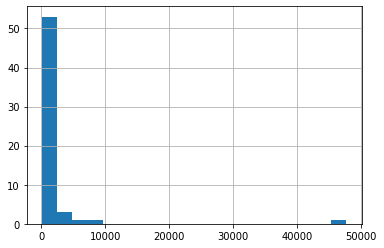

In [ ]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 20)

In [ ]:
from transformers import RobertaTokenizerFast
model_dir = "roberta"
tokenizer = PreTrainedTokenizerFast(tokenizer_file=os.path.join(model_dir, "tokenizer.json"))
tokenizer.pad_token = '<pad>'
roberta: RobertaModel = AutoModel.from_pretrained(model_dir)

In [ ]:
roberta

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50001, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 500,
    truncation=True,
    padding=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 500,
    truncation=True,
    padding=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 500,
    truncation=True,
    padding=True
)

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 10

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# specify GPU
device = torch.device("cuda")

In [ ]:

# freeze all the parameters
for param in roberta.parameters():
    param.requires_grad = False

In [ ]:
class ROBERTa_Arch(nn.Module):

    def __init__(self, roberta_):
      
      super(ROBERTa_Arch, self).__init__()

      self.roberta = roberta_
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.roberta(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = ROBERTa_Arch(roberta)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 0.0002)          # learning rate

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.84285714 1.22916667]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 120

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 120

Evaluating...

Training Loss: 0.711
Validation Loss: 0.749

 Epoch 2 / 120

Evaluating...

Training Loss: 0.692
Validation Loss: 0.677

 Epoch 3 / 120

Evaluating...

Training Loss: 0.679
Validation Loss: 0.660

 Epoch 4 / 120

Evaluating...

Training Loss: 0.675
Validation Loss: 0.646

 Epoch 5 / 120

Evaluating...

Training Loss: 0.669
Validation Loss: 0.649

 Epoch 6 / 120

Evaluating...

Training Loss: 0.650
Validation Loss: 0.668

 Epoch 7 / 120

Evaluating...

Training Loss: 0.649
Validation Loss: 0.688

 Epoch 8 / 120

Evaluating...

Training Loss: 0.635
Validation Loss: 0.648

 Epoch 9 / 120

Evaluating...

Training Loss: 0.637
Validation Loss: 0.606

 Epoch 10 / 120

Evaluating...

Training Loss: 0.641
Validation Loss: 0.622

 Epoch 11 / 120

Evaluating...

Training Loss: 0.626
Validation Loss: 0.652

 Epoch 12 / 120

Evaluating...

Training Loss: 0.615
Validation Loss: 0.597

 Epoch 13 / 120

Evaluating...

Training Loss: 0.621
Validation Loss: 0.588

 Epoch 

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1])

In [ ]:
test_y

tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0])

In [ ]:
print('ROBERTA')
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

ROBERTA
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.75      1.00      0.86         6

    accuracy                           0.85        13
   macro avg       0.88      0.86      0.85        13
weighted avg       0.88      0.85      0.84        13



In [ ]:
print('Most common value only')
print(classification_report(test_y, np.zeros(preds.shape[0], dtype=int)))

Most common value only
              precision    recall  f1-score   support

           0       0.54      1.00      0.70         7
           1       0.00      0.00      0.00         6

    accuracy                           0.54        13
   macro avg       0.27      0.50      0.35        13
weighted avg       0.29      0.54      0.38        13



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

preds_xgb = model_xgb.predict(D_test)
best_preds_xgb = np.asarray([np.argmax(line) for line in preds_xgb])
print('XGB model')
print(classification_report(best_preds_xgb, test_Y_tfidf))

XGB model
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        17
           1       0.82      1.00      0.90         9

    accuracy                           0.92        26
   macro avg       0.91      0.94      0.92        26
weighted avg       0.94      0.92      0.92        26



In [ ]:
import pandas as pd

y_actu = pd.Series(test_y, name='Actual')
y_pred = pd.Series(preds, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0,1
Actual,,
0,5,2
1,0,6


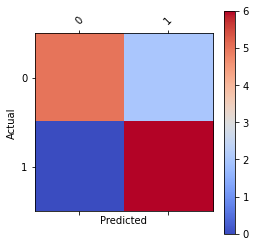

In [ ]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.coolwarm):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

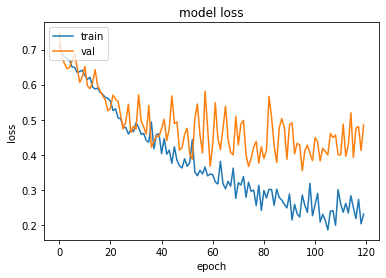

In [ ]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()